In [514]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
import matplotlib as mpl


In [534]:
images = [cv2.imread(f"Images/image{i}.png", cv2.IMREAD_COLOR)[:, :, ::-1] for i in range(1, 8)]
for i in range(len(images)):
    images[i] = cv2.resize(images[i], (int(images[i].shape[1] * 800 / images[i].shape[0]), 800))

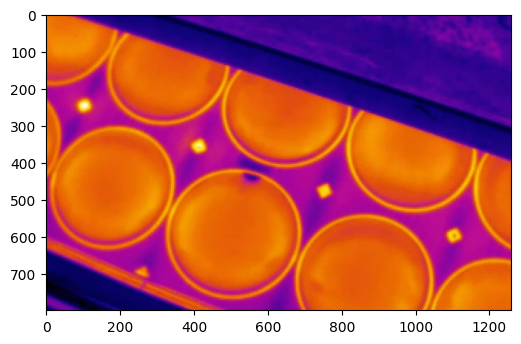

In [543]:
mpl.rcParams['figure.dpi'] = 100
plt.imshow(images[1])

## First, trying to do so with some basic methods that work with binary dilation and erosion

We can see that the blue channel has a lot of difference on objects we need to count and background. Lets' try to make a binary image out of it using thresholding, and working with these binary images afterwards. Here, I saw that the most interesting information is stored in green and blue channels, so I transform the image to grayscale using just them in a way to make objects distinguishable


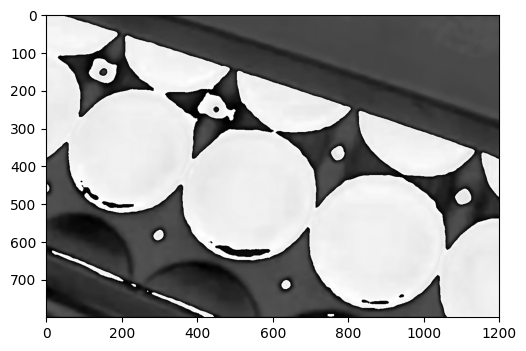

In [544]:
image_idx = 0
img = images[image_idx].copy()

# Remove noise by using the median filter
img = cv2.medianBlur(img, 11)
plt.imshow(img[:, :, 2] // 2 - img[:, :, 1] // 6, cmap='gray')

#### Looks like objects should be easily distinguishable after some thresholding

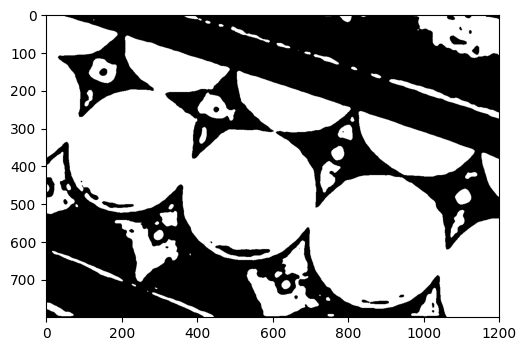

In [545]:
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret, th = cv2.threshold(blur[:, :, 2] // 2 - blur[:, :, 1] // 6, 75, 255, cv2.THRESH_BINARY)
plt.imshow(th, cmap='gray')

#### Now applying dilation and erostion to get rid of not needed details and to separate objects

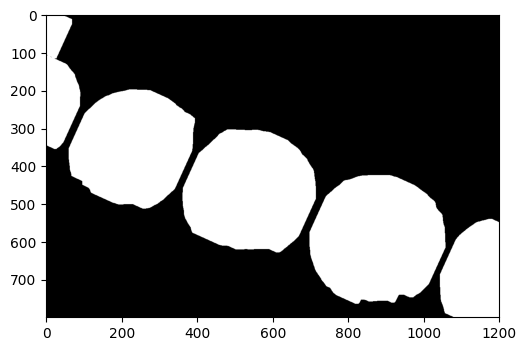

In [546]:
kernel = np.zeros((55, 25), dtype=np.uint8)
cv2.line(kernel, (0, 55), (25, 0), thickness=4, color=255)

kernel2 = np.zeros((25, 55), dtype=np.uint8)
cv2.line(kernel2, (0, 0), (55, 25), thickness=4, color=255)
plt.imshow(kernel2, cmap='gray')

opened_image = cv2.morphologyEx(th, cv2.MORPH_ERODE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel2)

opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel2)

# opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel)

plt.imshow(opened_image, cmap='gray')


#### Now I count size of each individual objects in pixels, and select only ones larget than 50000 pixels and that are not touching sides of the image. I use BFS for this, which is pretty slow, however

In [547]:
# Here, I find the contour of each object and run BFS to find out how many pixels it contains.
# This takes a long time, but I couldn't find any algorithm for this in OpenCV

objects, contours = cv2.findContours(opened_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
valid = 0

dx = [-1, -1, 0, 1, 1, 1, 0, -1]
dy = [0, 1, 1, 1, 0, -1, -1, -1]

for obj in objects:
    s_x = 0
    s_y = 0
    s = 0

    q = Queue()
    q.put((obj[0][0][1], obj[0][0][0]))
    used = {(obj[0][0][1], obj[0][0][0])}
    may_be_valid = True

    while not q.empty():
        x, y = q.get()
        s_x += x
        s_y += y
        s += 1

        if x == opened_image.shape[0] - 1 or x == 0 or y == 0 or y == opened_image.shape[1] - 1:
            may_be_valid = False
            break

        for i in range(8):
            new_x = x + dx[i]
            new_y = y + dy[i]

            if (new_x, new_y) not in used and 0 <= new_x < opened_image.shape[0] and 0 <= new_y < opened_image.shape[
                1] and opened_image[new_x, new_y] != 0:
                q.put((new_x, new_y))
                used.add((new_x, new_y))

            # break
    print(f"Mean: {s_x / s}, {s_y / s}, {s}, {may_be_valid}")
    if may_be_valid and s > 50000:
        valid += 1

print(valid)


Mean: 556.221935483871, 1170.1864516129033, 1550, False
Mean: 593.8183455458587, 875.429575580438, 97168, True
Mean: 466.59321059959774, 538.005271067695, 90494, True
Mean: 350.9658508320002, 227.92261957247408, 79387, True
Mean: 0.0, 0.0, 1, False
Mean: 111.01302460202605, 13.451519536903039, 691, False
Mean: 110.05389221556887, 11.548902195608783, 501, False
3


### And a combined version of all above with all of the images

In [548]:

object_locations = []

for image_idx in range(7):
    img = images[image_idx].copy()
    img = cv2.resize(img, (int(img.shape[1] * 800 / img.shape[0]), 800))

    # Remove noise by using the median filter
    img = cv2.medianBlur(img, 11)

    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret, th = cv2.threshold(blur[:, :, 2] // 2 - blur[:, :, 1] // 6, 75, 255, cv2.THRESH_BINARY)

    kernel = np.zeros((55, 25), dtype=np.uint8)
    cv2.line(kernel, (0, 55), (25, 0), thickness=4, color=255)

    kernel2 = np.zeros((25, 55), dtype=np.uint8)
    cv2.line(kernel2, (0, 0), (55, 25), thickness=4, color=255)

    opened_image = cv2.morphologyEx(th, cv2.MORPH_ERODE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel2)

    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel2)

    objects, contours = cv2.findContours(opened_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    valid = 0

    object_locations.append([])

    dx = [-1, -1, 0, 1, 1, 1, 0, -1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]

    for obj in objects:
        s_x = 0
        s_y = 0
        s = 0

        q = Queue()
        q.put((obj[0][0][1], obj[0][0][0]))
        used = {(obj[0][0][1], obj[0][0][0])}
        may_be_valid = True

        while not q.empty():
            x, y = q.get()
            s_x += x
            s_y += y
            s += 1

            if x == opened_image.shape[0] - 1 or x == 0 or y == 0 or y == opened_image.shape[1] - 1:
                may_be_valid = False
                break

            for i in range(8):
                new_x = x + dx[i]
                new_y = y + dy[i]

                if (new_x, new_y) not in used and 0 <= new_x < opened_image.shape[0] and 0 <= new_y < \
                        opened_image.shape[1] and opened_image[new_x, new_y] != 0:
                    q.put((new_x, new_y))
                    used.add((new_x, new_y))

        if may_be_valid and s > 50000:
            object_locations[-1].append((s_x / s, s_y / s))
            valid += 1

    print(f"For image {image_idx + 1} the algorithm found {valid} objects on the image")
    # should be 3 2 2 1 2 2 1

For image 1 the algorithm found 3 objects on the image
For image 2 the algorithm found 2 objects on the image
For image 3 the algorithm found 2 objects on the image
For image 4 the algorithm found 1 objects on the image
For image 5 the algorithm found 2 objects on the image
For image 6 the algorithm found 2 objects on the image
For image 7 the algorithm found 1 objects on the image


#### Plotting the result with marked object centers

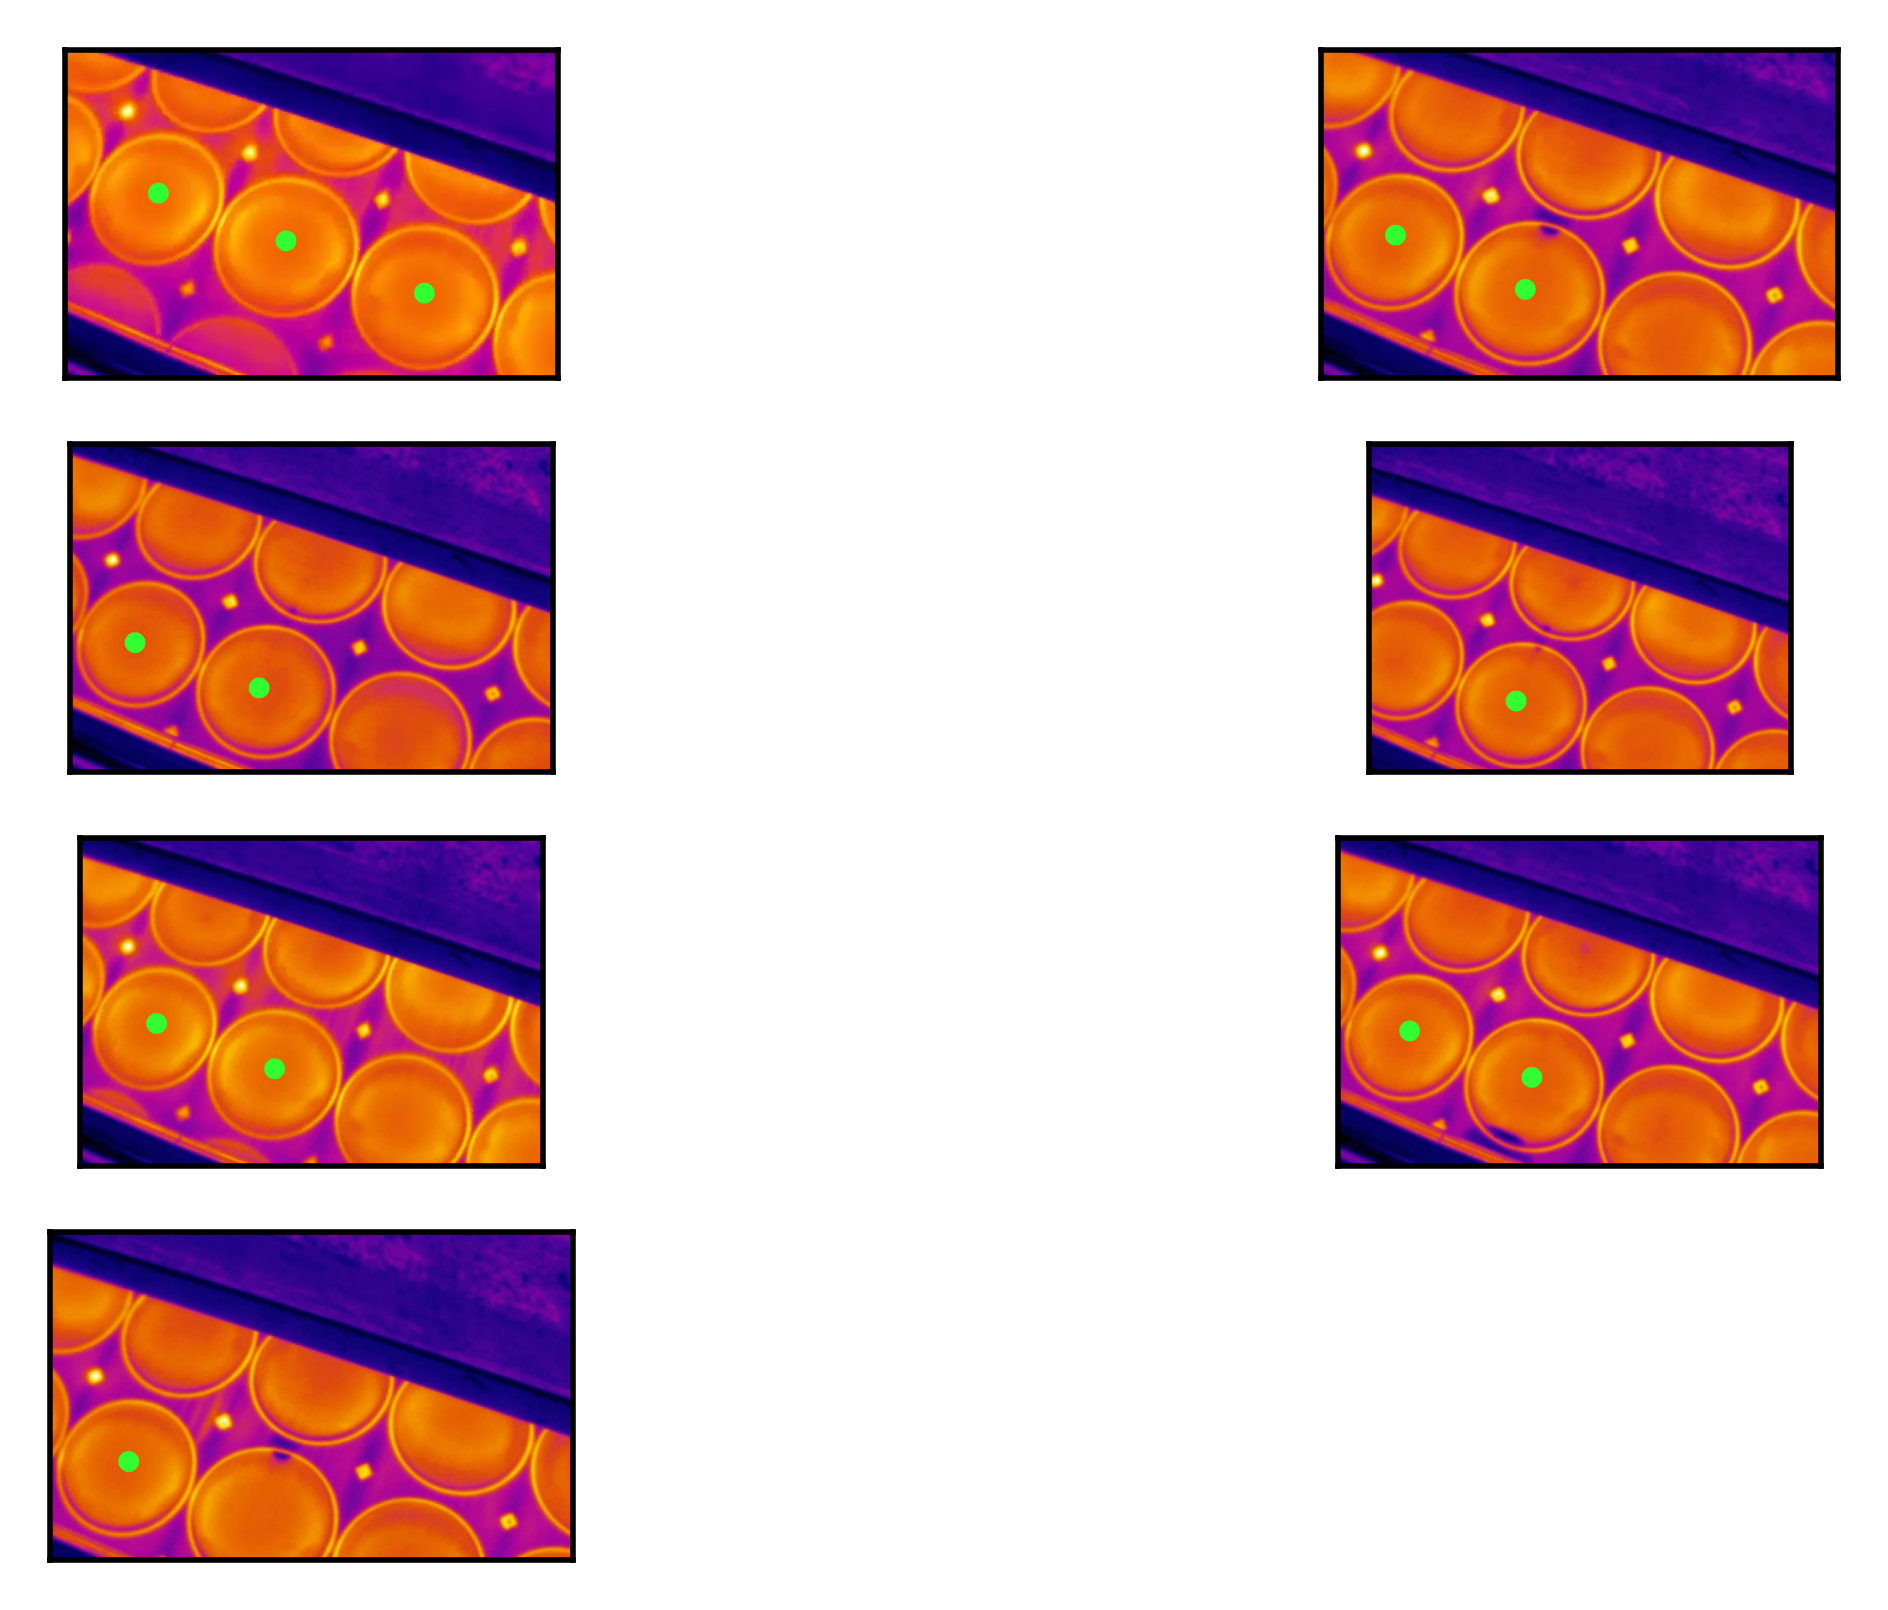

In [629]:
mpl.rcParams['figure.dpi'] = 500
for i in range(7):
    plt.subplot(4, 2, i + 1)
    img_marked = images[i].copy()
    for obj in object_locations[i]:
        # print(int(obj[1], obj[0])
        cv2.circle(img_marked, (int(obj[1]), int(obj[0])), 10, (50, 255, 50), thickness=30)

    plt.imshow(img_marked)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

### The approach above is sensitive to any small changes, and may not work very robustly if the illumination changes, or when an object is very close to the frame edge. Here, I try another approach using HoughCircles from OpenCV

In [857]:
images = [cv2.imread(f"Images/image{i}.png", cv2.IMREAD_COLOR)[:, :, ::-1] for i in range(1, 8)]

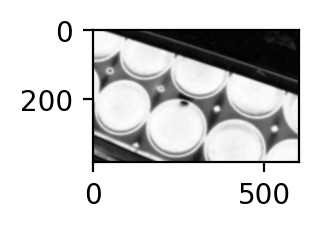

In [900]:

## THIS IS PIECE OF SHIT AND FAILED TRIES TO COME UP WITH SOMETHING INTERESTING
mpl.rcParams['figure.dpi'] = 200
image_idx = 1
color = [8, 165, 241]

for image_idx in range(1, 2):
    plt.subplot(4, 2, image_idx + 1)

    img = images[image_idx].copy()
    # img = cv2.resize(img, (img.shape[1] + 25, img.shape[0]))
    img = cv2.GaussianBlur(img, (11, 11), 0)

    gray = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray[i][j] = int(np.linalg.norm((img[i, j, :] -  [8, 165, 241])) / 1.73)


    # img[:,:,0] = img[:,:,0] + 20
    # img[:,:,1] = img[:,:,1] / 2
    # img[:,:,2] = img[:,:,2] / 2
    # gray = img[:, :, 2] // 2 - img[:, :, 1] // 2
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray[gray < 100] = 0
    plt.imshow(gray, cmap='gray')


    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=20, param2=25, minRadius=40, maxRadius=160)



    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 7)
            # Draw the center of the circle
            cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 15)

    # plt.imshow(img)